In [7]:
#
# In this notebook we exampine moprhology's rol,e of preicpitaiton system
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_land_mask import globe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
CORE_THRESH = 10
regions = [
    afc_region(), 
    cio_region(), 
    wmp_region(), 
    h01_region(), 
    h05_region(), 
    epo_region(),
    sam_region(),
    sas_region()
]

pf_stats = pd.concat(
    [load_pf_stats(r, maxpr_min=CORE_THRESH) for r in regions]
)

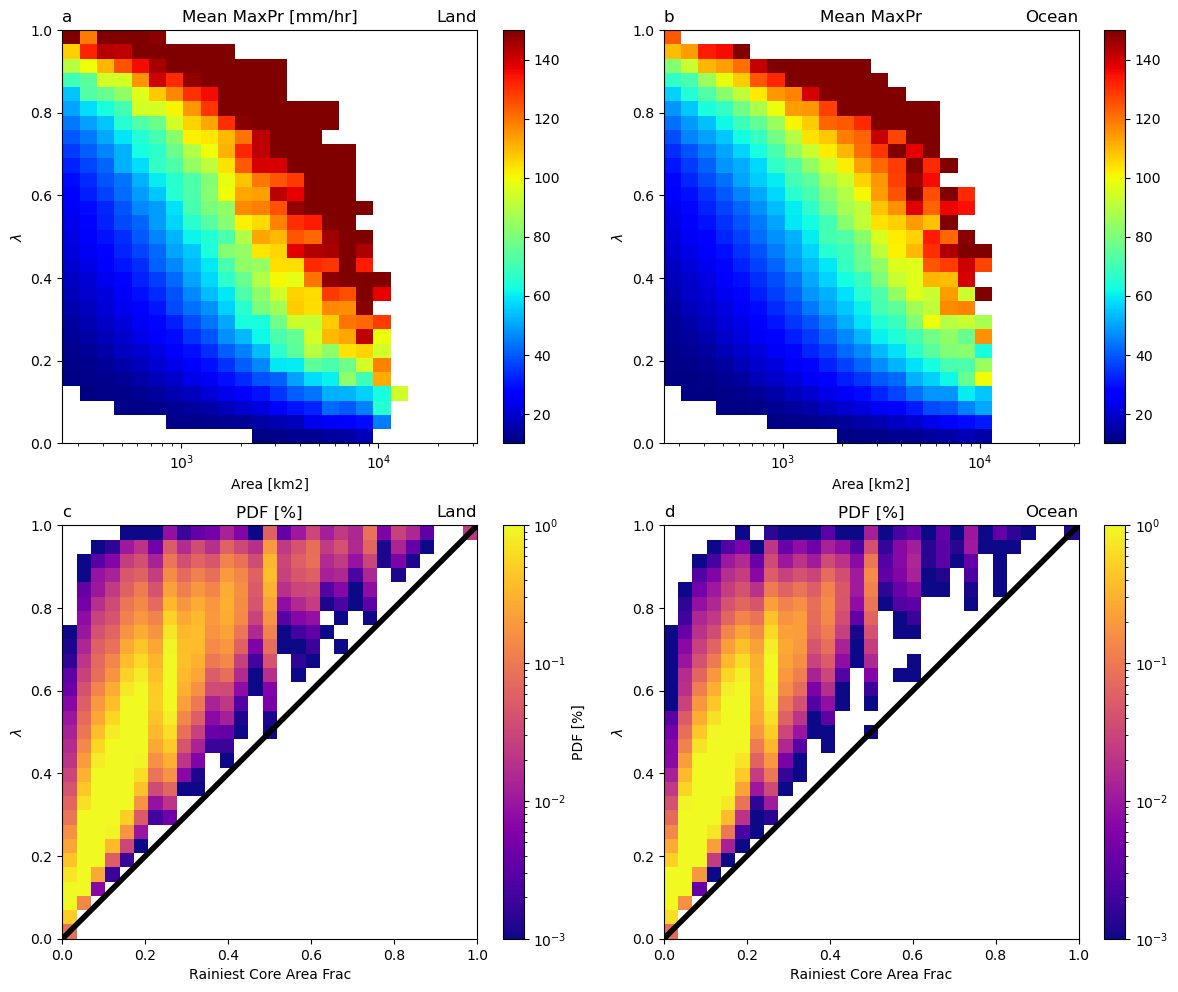

In [67]:
#
# We make a figure of the PDF of area, loc, and area fraction
#
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))

is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

area = pf_stats['num_pixels'] * 25
loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
sigma = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_size_8conn']/pf_stats['num_pixels']
max_pr = pf_stats['max_precip']

area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
sigma_bins = np.linspace(0, 1, 30)

def plot_maxpr_mean(ax, maxpr, loc, area):
    mean = binned_statistic_2d(
        x=loc, 
        y=area, 
        values=maxpr, 
        bins=[loc_bins, area_bins], 
        statistic=lambda x: np.nanmean(x) if x.size>5 else np.nan
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
            x_mesh, 
            y_mesh, 
            mean, 
            cmap=plt.cm.jet, 
            norm=colors.Normalize(vmin=10, vmax=150)
        )
    ax.set_xscale('log')
    ax.set_xlabel('Area [km2]')
    ax.set_ylabel(r'$\lambda$')
    return c  # Return the mappable object so we can attach a colorbar

def plot_loc_vs_sigma(ax, loc, sigma):
    count = binned_statistic_2d(
        x=loc, 
        y=sigma, 
        values=None, 
        bins=[loc_bins, sigma_bins], 
        statistic='count'
    ).statistic

    pdf = 100*count/count.sum()
    
    x_mesh, y_mesh = np.meshgrid(sigma_bins, loc_bins)
    c = ax.pcolormesh(
            x_mesh, 
            y_mesh, 
            pdf, 
            cmap=plt.cm.plasma, 
            norm=colors.LogNorm(vmin=1e-3, vmax=1e0)
        ) 
    ax.set_xlabel('Rainiest Core Area Frac')
    ax.set_ylabel(r'$\lambda$')
    ax.plot([0,1], [0,1], color='black', lw=4)
    return c  # Return the mappable object so we can attach a colorbar

#
# Top-left
#
ax = axs[0,0]
c = plot_maxpr_mean(
    ax=ax, 
    maxpr=max_pr[is_land_id], 
    loc=loc[is_land_id],
    area=area[is_land_id]    
)
fig.colorbar(c, ax=ax)
ax.set_title('Land', loc='right')
ax.set_title('Mean MaxPr [mm/hr]', loc='center')
ax.set_title('a', loc='left')

#
# Top-right
#
ax = axs[0,1]
c = plot_maxpr_mean(
    ax=ax, 
    maxpr=max_pr[is_ocean_id], 
    loc=loc[is_ocean_id],
    area=area[is_ocean_id]    
)
fig.colorbar(c, ax=ax)
ax.set_title('Ocean', loc='right')
ax.set_title('Mean MaxPr', loc='center')
ax.set_title('b', loc='left')

#
# Bottom-left
#
ax = axs[1,0]
ax.set_title('Land')
c = plot_loc_vs_sigma(
    ax=ax, 
    loc=loc[is_land_id],
    sigma=sigma[is_land_id]    
)
fig.colorbar(c, ax=ax, label='PDF [%]')
ax.set_title('Land', loc='right')
ax.set_title('PDF [%]', loc='center')
ax.set_title('c', loc='left')

#
# Bottom-right
#
ax = axs[1,1]
ax.set_title('Ocean')
c = plot_loc_vs_sigma(
    ax=ax, 
    loc=loc[is_ocean_id],
    sigma=sigma[is_ocean_id]    
)
cb = fig.colorbar(c, ax=ax)

ax.set_title('Ocean', loc='right')
ax.set_title('PDF [%]', loc='center')
ax.set_title('d', loc='left')

fig.tight_layout(pad=1)
plt.show()
save_figure(fig, 'Fig03_MaxPr')
